# Description of the code: 

### 1. Load the video  
It can be a tiff video file or a folder containing tiff images. Other fromats are possible but require to adapt the code line that converts the video into a numpy array. 
### 2. Specify the camera framerate
Units: Hz
### 3. Choose a downscaling parameter to speed the computation
### 4. Choose a thresholding method
### 5. Select the fit range
First and last frame to use for the fit
### 6. Assess that there is no saturated pixels
### 7. Run the pixel-per-pixel fit
### 8. Display the result
### 9. Load the raw data for visualisation with the code "display_curves.ipynb"

### **Instructions to run the code can be found [here](https://github.com/DreamRepo/light_calibration#usage)**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from joblib import Parallel

from useful_func import *


from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from scipy.ndimage import binary_erosion


import tifffile as tiff
from tqdm import tqdm

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

import click

#%matplotlib widget

In [3]:
file_default = "../data/video_light.tiff"

file = click.prompt("Enter the file or folder path", type=str, default=file_default)

if os.path.isfile(file):
    video = tiff.imread(file)
    
elif os.path.isdir(file):
    video = []
    for im in tqdm(glob.glob(file + "/*.tiff")):
        video.append(tiff.imread(im))
    video = np.array(video)
    
else:
    print('wrong path')
    
    


Enter the file or folder path [../data/video_light.tiff]:

In [4]:
framerate = click.prompt("Camera framerate (Hz)", type=int, default=3)
timing = np.linspace(0, len(video)-1, len(video))/framerate

Camera framerate [3]:

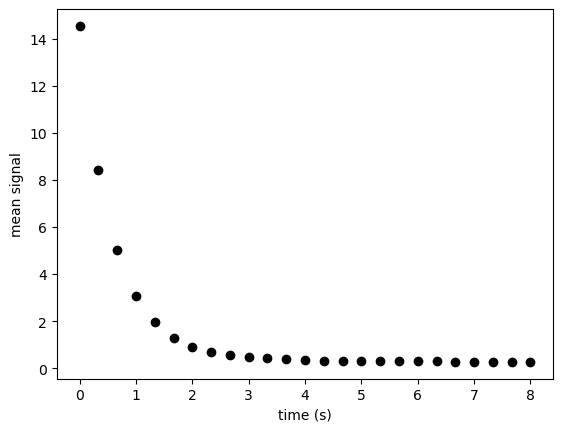

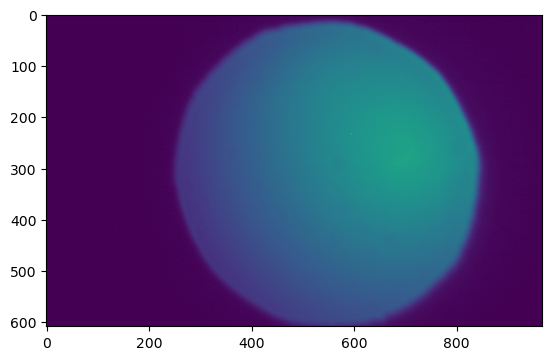

In [5]:
plt.xlabel('time (s)')
plt.ylabel('mean signal')
plt.plot(timing, np.mean(video[0:], axis = (1,2)), "ko")
plt.figure()

slices = np.mean(video, axis = (1,2))
frames = video[slices>np.quantile(slices, 0.8)]
frame_ref = np.mean(frames, axis =0)
plt.imshow(frame_ref)

In [6]:
D = click.prompt("smoothing & downscaling factor to accelerate computations", type=int, default=5)
D_image = downscale_local_mean(frame_ref, (D,D))

#downscaling 
video_downscaled = []
for i in range(0, video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]


smoothing & downscaling factor to accelerate computations [5]:

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


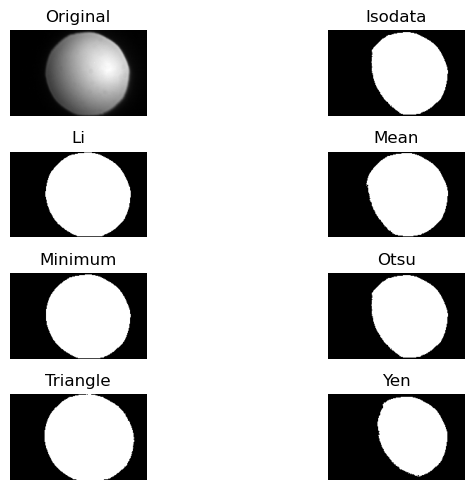

In [7]:
u = skimage.filters.try_all_threshold(D_image)


copy the name of the thresholding method that suits you (no caps). If none suits, enter None [minimum]:

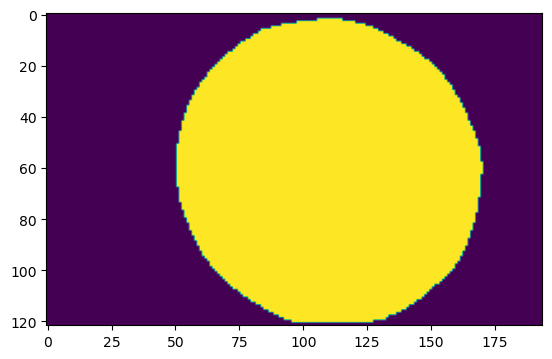

In [8]:
threshold_method = threshold_convert(click.prompt("copy the name of the thresholding method that suits you (no caps). If none suits, enter None", type = str, default="minimum"))

video = np.array(video)
timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
threshold = threshold_method(D_image)

mask = D_image>threshold
plt.imshow(mask)



Text(0, 0.5, 'fluorescence')

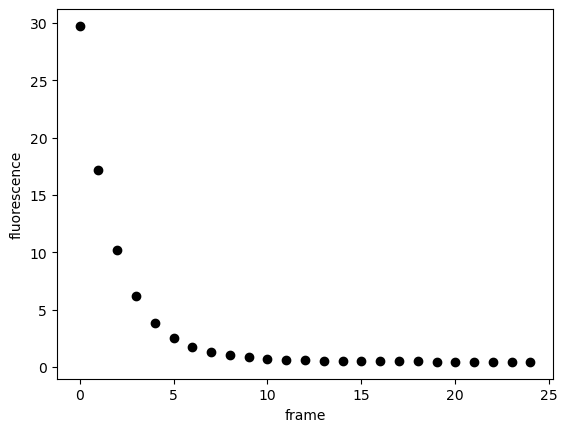

In [9]:
video_2D = np.copy(video_downscaled)
video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

to_evaluate = video_downscaled[:,mask.flatten()]

plt.plot(np.mean(to_evaluate, axis = 1), 'ok')
plt.xlabel('frame')
plt.ylabel('fluorescence')

First useful frame [0]:

Last useful frame [25]:

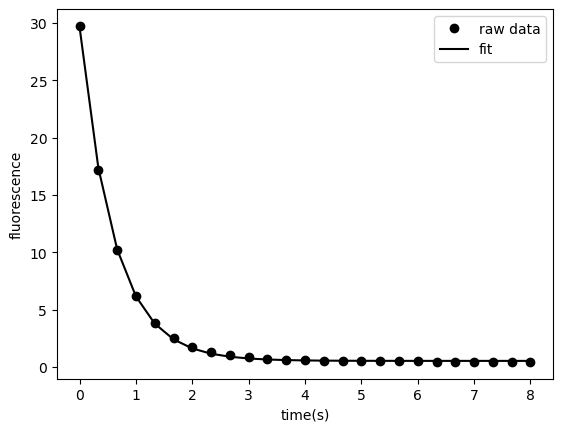

In [10]:
start = click.prompt("First useful frame", type=int, default=0)
stop = click.prompt("Last useful frame", type=int, default=25)


#fit on the mean value before performing the fit on each pixel
params = simple_tau(np.mean(to_evaluate[start:stop], axis = 1), timing[start:stop], sample_rate = framerate)

time = timing[start:stop]
time -= time[0]
plt.plot(time, np.mean(to_evaluate[start:stop], axis = 1), "ok", label = "raw data")
plt.plot(time, exp_decay(params, time), "k", label = "fit")
plt.xlabel('time(s)')
plt.ylabel("fluorescence")
plt.legend()
plt.savefig(save_folder + "mean_decay_fit_D2.png")

In [11]:
sat = np.sum(to_evaluate[0]==255)/len(to_evaluate[0].flatten())*100
print("percent of saturated pixels in the mask: ", sat)

if sat > 2:
    print("WARNING, more than 2% of the pixels are saturated on the first frame, try acquiring the movie with shorter exposure/smaller gain.")

percent of saturated pixels in the mask:  0.0


In [12]:
#parallel fit on each pixel of the mask
tau_lists = Parallel(n_jobs = -1 )(parallel_tau(to_evaluate[start:stop,i], timing[start:stop], sample_rate = framerate) for i in tqdm(range(to_evaluate.shape[1])))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11248/11248 [00:13<00:00, 863.24it/s]


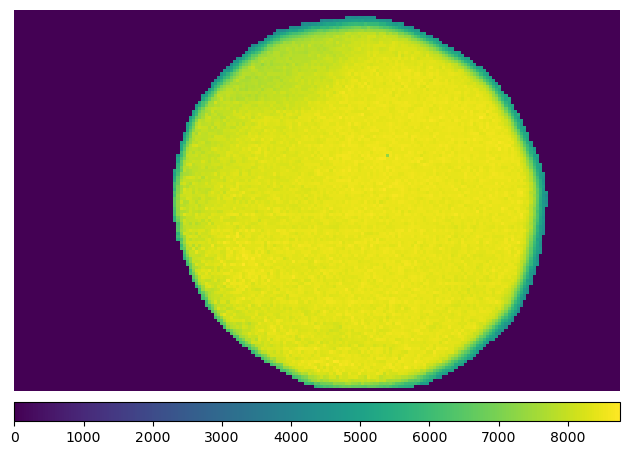

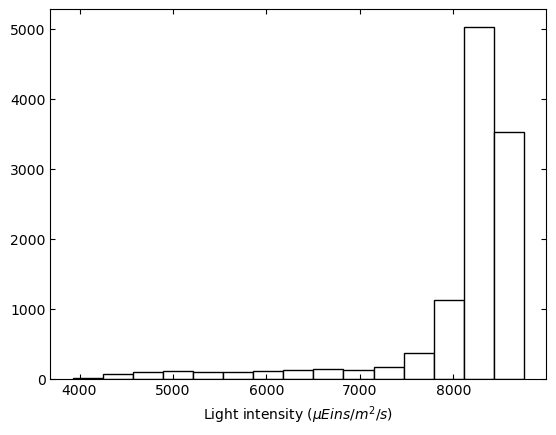

In [13]:
tau_480 = np.array(tau_lists)
tau_480_map = np.zeros(mask.shape)
tau_480_map[mask] = tau_480


I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480

np.save("../images/I_480_map.npy", I_480_map)

plt.rcParams['image.cmap'] = 'viridis'


 
I, dis = plot_map(I_480, I_480_map,"test_app" + "_I_480_map_B" + extension, limits = (0, 12000))

np.save("../images/video_2D.npy", video_2D[start:stop])
np.save("../images/framerate.npy", framerate)


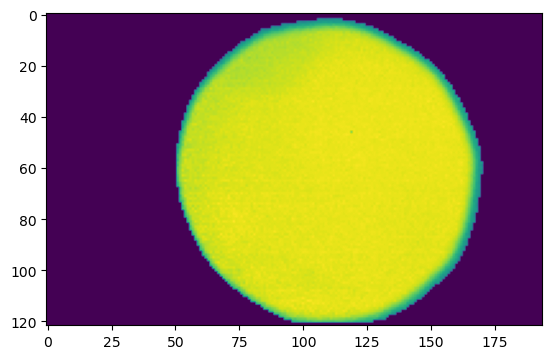

In [14]:
plt.imshow(I_480_map)